# Identify the indian classical dance forms

This notebook is trying to classify between to four predominant sugarcane crop's diseases as:
- White Leaf Disease
- Rust
- Mosaic
- Red rot
<br/>
Purpose is to be able to identify which out of four disease is mort likely is being seen in the image, which can be used by farmers in India to get the respective remediation help!

In [4]:
# set magic commands
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Import fastai's required modules.

In [5]:
from fastai import *
from fastai.vision import *
from pathlib import PosixPath

## Looking at the data

We are going to use the manually curated dataset by myself from google images. Total we have **270 images**, out of which images are distributed as: <br/>
- White Leaf Disease : 50 images
- Rust : 120 images
- Mosaic : 56 images
- Red Rot : 44 images 

Commands used to download these commands are: <br/>
googleimagesdownload -k "sugarcane red rot" -s medium -l 500 -o sugarcane -i red-rot -cd /Users/sasingsi/Documents/GoogleDrive/fastai-v3/downloads/chromedriver/chromedriver <br/>
googleimagesdownload -k "sugarcane mosaic" -s medium -l 500 -o sugarcane -i mosaic -cd /Users/sasingsi/Documents/GoogleDrive/fastai-v3/downloads/chromedriver/chromedriver<br/>
googleimagesdownload -k "sugarcane rust leaf spots" -s medium -l 500 -o sugarcane -i rust -cd /Users/sasingsi/Documents/GoogleDrive/fastai-v3/downloads/chromedriver/chromedriver<br/>
googleimagesdownload -k "sugarcane white leaf disease" -s medium -l 500 -o sugarcane -i white-leaf-disease -cd /Users/sasingsi/Documents/GoogleDrive/fastai-v3/downloads/chromedriver/chromedriver<br/>
<br/>
We had to do little bit of post download processing to have file-names as:<br/>
kathakali_1.jpg, kathakali_2.jpg, kathakali_3.jpg, ... <br/>
white-leaf-disease_1.jpg, white-leaf-disease_2.jpg, white-leaf-disease_3.jpg, ...<br/>
rust_1.jpg, rust_2.jpg, rust_3.jpg, ...<br/>
mosaic_1.jpg, mosaic_2.jpg, mosaic_3.jpg, ...<br/>
red-rot_1.jpg, red-rot_2.jpg, red-rot_3.jpg, ...<br/>


<br/>
Reason for having these files named in above mentioned patter is to make use of FastAI's wonderfull api as:<br/>
*ImageDataBunch.from_name_re()<br/>*
It takes parent folders pathlib object and list of pathlib objects for all the images in folder. Extracts the lables using name of each image via regular expression passed. Returns **ImageDataBunch** object.<br/>

Our model will need to learn to differentiate between these **4 distinct categories.**<br/>

Let's see how accurate we can be using deep learning!<br/>

Upload the images from source to destination as:
- Zip the folder as: zip -r all-sugarcane-diseases.zip all-sugarcane-diseases
- Upload the zip file to google drive.
- Get the wget URL for zip in google drive to download it.
- Paste the wget URL in GCP host machine. 
- Unzip the downloaded file.

In [6]:
# Print current directory and location of our jupyter notebook
!pwd
!ls -lt ss-sugarcane-disease-classification.ipynb

/home/jupyter/tutorials/fastai/nbs/dl1
-rw-r--r-- 1 jupyter jupyter 1379533 Oct 31 20:57 ss-sugarcane-disease-classification.ipynb


In [8]:
!ls -lt /home/jupyter/.fastai/data/all-sugarcane-diseases/ | grep "white-leaf-disease" | head -n3
!ls -lt /home/jupyter/.fastai/data/all-sugarcane-diseases/ | grep "mosaic" | head -n3
!ls -lt /home/jupyter/.fastai/data/all-sugarcane-diseases/ | grep "red-rot" | head -n3
!ls -lt /home/jupyter/.fastai/data/all-sugarcane-diseases/ | grep "rust" | head -n3

-rwxrwxrwx 1 jupyter jupyter   65357 Oct 31 00:35 white-leaf-disease_11.jpg
-rwxrwxrwx 1 jupyter jupyter   59001 Oct 31 00:35 white-leaf-disease_12.jpg
-rwxrwxrwx 1 jupyter jupyter   47925 Oct 31 00:35 white-leaf-disease_13.jpg
-rwxrwxrwx 1 jupyter jupyter   23287 Oct 31 00:35 mosaic_44.jpg
-rwxrwxrwx 1 jupyter jupyter  345824 Oct 31 00:35 mosaic_45.jpg
-rwxrwxrwx 1 jupyter jupyter   47007 Oct 31 00:35 mosaic_50.jpg
-rwxrwxrwx 1 jupyter jupyter  104663 Oct 31 00:35 red-rot_44.jpg
-rwxrwxrwx 1 jupyter jupyter  655071 Oct 31 00:35 red-rot_8.jpg
-rwxrwxrwx 1 jupyter jupyter   46704 Oct 31 00:35 red-rot_40.jpg
-rwxrwxrwx 1 jupyter jupyter  167601 Oct 31 00:35 rust_12.jpg
-rwxrwxrwx 1 jupyter jupyter   32498 Oct 31 00:35 rust_13.jpg
-rwxrwxrwx 1 jupyter jupyter  119424 Oct 31 00:35 rust_10.jpg


In [9]:
path_img = PosixPath('/home/jupyter/.fastai/data/all-sugarcane-diseases/'); path_img # this is Python 3's pathlib type of object

PosixPath('/home/jupyter/.fastai/data/all-sugarcane-diseases')

In [10]:
path_img.ls()[:10]

[PosixPath('/home/jupyter/.fastai/data/all-sugarcane-diseases/rust_24.jpg'),
 PosixPath('/home/jupyter/.fastai/data/all-sugarcane-diseases/rust_36.jpg'),
 PosixPath('/home/jupyter/.fastai/data/all-sugarcane-diseases/rust_73.jpg'),
 PosixPath('/home/jupyter/.fastai/data/all-sugarcane-diseases/red-rot_19.jpg'),
 PosixPath('/home/jupyter/.fastai/data/all-sugarcane-diseases/rust_115.jpg'),
 PosixPath('/home/jupyter/.fastai/data/all-sugarcane-diseases/rust_91.jpg'),
 PosixPath('/home/jupyter/.fastai/data/all-sugarcane-diseases/mosaic_51.jpg'),
 PosixPath('/home/jupyter/.fastai/data/all-sugarcane-diseases/mosaic_55.jpg'),
 PosixPath('/home/jupyter/.fastai/data/all-sugarcane-diseases/white-leaf-disease_1.jpg'),
 PosixPath('/home/jupyter/.fastai/data/all-sugarcane-diseases/rust_112.jpg')]

The first thing we do when we approach a problem is to take a look at the data. We _always_ need to understand very well what the problem is and what the data looks like before we can figure out how to solve it. Taking a look at the data means understanding how the data directories are structured, what the labels are and what some sample images look like.

**The main difference between** the handling of image classification datasets is the way labels are stored.<br/> In this particular dataset, labels are stored in the filenames themselves. We will need to extract them to be able to classify the images into the correct categories. Fortunately, the fastai library has a handy function made exactly for this, **`ImageDataBunch.from_name_re`** gets the labels from the filenames using a [regular expression](https://docs.python.org/3.6/library/re.html).

In [9]:
doc(get_image_files)

In [11]:
# Get the list of PosixPath objects for the image type files in passed PosixPath for folder.
fnames = get_image_files(path_img)
fnames[:5]

[PosixPath('/home/jupyter/.fastai/data/all-sugarcane-diseases/rust_24.jpg'),
 PosixPath('/home/jupyter/.fastai/data/all-sugarcane-diseases/rust_36.jpg'),
 PosixPath('/home/jupyter/.fastai/data/all-sugarcane-diseases/rust_73.jpg'),
 PosixPath('/home/jupyter/.fastai/data/all-sugarcane-diseases/red-rot_19.jpg'),
 PosixPath('/home/jupyter/.fastai/data/all-sugarcane-diseases/rust_115.jpg')]

In [12]:
# 270 files
len(fnames)

265

In [13]:
# Explanation of Regular Expression
# https://medium.com/@youknowjamest/parsing-file-names-using-regular-expressions-3e85d64deb69
# e.g.
import re
regex = re.compile(r'/([^/]+)_\d+.jpg$')
regex.findall('/home/jupyter/.fastai/data/all-sugarcane-diseases/white-leaf-disease_13.jpg')

['white-leaf-disease']

In [14]:
np.random.seed(2)
pat = r'/([^/]+)_\d+.jpg$'

In [15]:
# from_name_re() method get the lables for classed by using regex on the file names
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(), size=224)

data.normalize(imagenet_stats)
# Pixel values of images ranges from 0 to 255. Images generally contains 3 colour channels (Red, Green and blue). 
# Some times some channels will be bright , some might be dull. Some might vary so much and some might not vary at all.
# It really helps to train a model if all those 3 channels has got pixel values mean at 0 and standard deviation at 1.
# Normalization simply does that.

In [15]:
imagenet_stats

([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

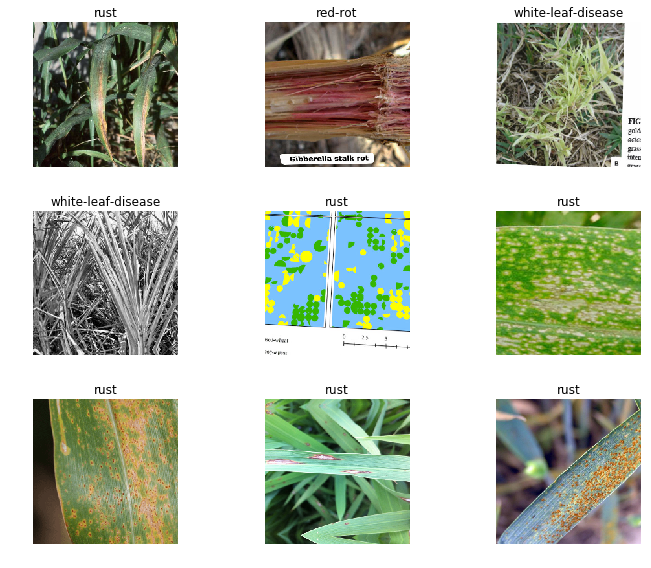

In [16]:
data.show_batch(rows=3, figsize=(10,8))

In [17]:
print(data.classes)
len(data.classes),data.c

['rust', 'red-rot', 'mosaic', 'white-leaf-disease']


(4, 4)

## Training: resnet34

Now we will start training our model. We will use a [convolutional neural network](http://cs231n.github.io/convolutional-networks/) backbone and a fully connected head with a single hidden layer as a classifier. Don't know what these things mean? Not to worry, we will dive deeper in the coming lessons. For the moment you need to know that we are building a model which will take images as input and will output the predicted probability for each of the categories (in this case, it will have 4 ouptuts).

We will train for 5 epochs (5 cycles through all our data).

In [18]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

In [19]:
learn.fit_one_cycle(10) # Just run training for one cycle of 4 epochs

Total time: 00:39
epoch  train_loss  valid_loss  error_rate
1      1.573112    1.202515    0.584906    (00:05)
2      1.414192    0.876692    0.358491    (00:03)
3      1.226333    0.694814    0.245283    (00:03)
4      1.061488    0.694685    0.283019    (00:03)
5      0.940042    0.725060    0.245283    (00:03)
6      0.831806    0.738873    0.226415    (00:03)
7      0.757284    0.735847    0.226415    (00:03)
8      0.701222    0.742560    0.264151    (00:03)
9      0.631035    0.746311    0.245283    (00:03)
10     0.587226    0.754785    0.283019    (00:03)



In [20]:
learn.save('all-sugarcane-diseases-stage-1')

## Results

Let's see what results we have got. 

We will first see which were the categories that the model most confused with one another. We will try to see if what the model predicted was reasonable or not. In this case the mistakes look reasonable (none of the mistakes seems obviously naive). This is an indicator that our classifier is working correctly. 

Furthermore, when we plot the confusion matrix, we can see that the distribution is heavily skewed: the model makes the same mistakes over and over again but it rarely confuses other categories. This suggests that it just finds it difficult to distinguish some specific categories between each other; this is normal behaviour.

In [21]:
interp = ClassificationInterpretation.from_learner(learn)

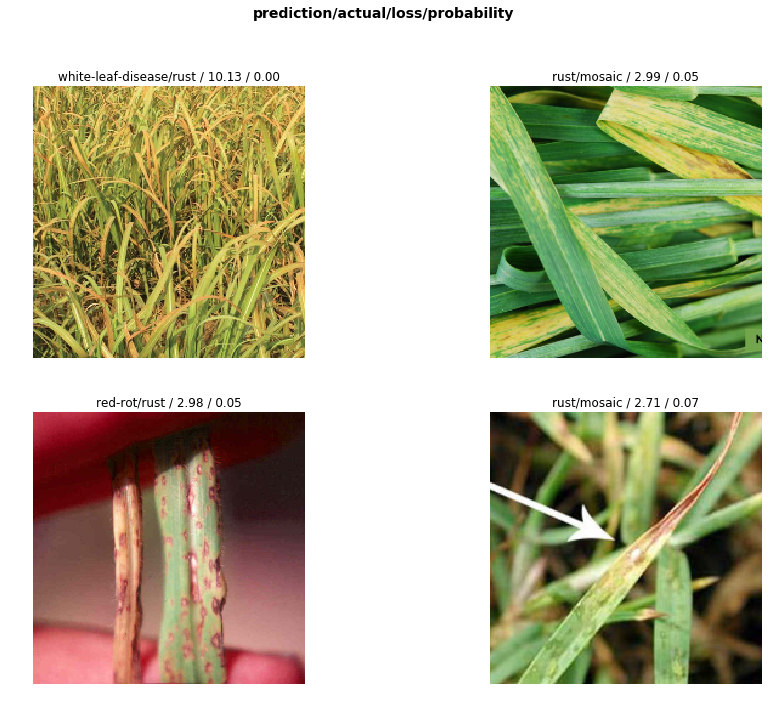

In [22]:
interp.plot_top_losses(4, figsize=(15,11))

In [23]:
doc(interp.plot_top_losses)

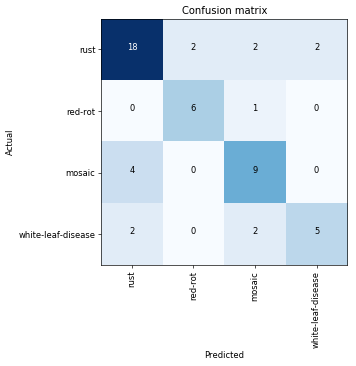

In [24]:
interp.plot_confusion_matrix(figsize=(6,6), dpi=60)

In [25]:
interp.most_confused(min_val=0)

[('mosaic', 'rust', 4),
 ('rust', 'red-rot', 2),
 ('rust', 'mosaic', 2),
 ('rust', 'white-leaf-disease', 2),
 ('white-leaf-disease', 'rust', 2),
 ('white-leaf-disease', 'mosaic', 2),
 ('red-rot', 'mosaic', 1)]

## Unfreezing, fine-tuning, and learning rates

Since our model is working as we expect it to, we will *unfreeze* our model and train some more.

In [26]:
learn.unfreeze()

In [27]:
learn.fit_one_cycle(5)

Total time: 00:21
epoch  train_loss  valid_loss  error_rate
1      0.477028    0.950045    0.339623    (00:04)
2      0.630138    2.978192    0.452830    (00:04)
3      0.613692    4.659200    0.547170    (00:04)
4      0.554531    3.660967    0.377358    (00:03)
5      0.493953    2.035471    0.320755    (00:04)



So, just by unfreezing all the layers and training them with same default learning rate has caused the error rate to go much higher. This sounds conter-intuitive, but actually it is not. <br/>
Reason being, unfreezing all layers and training them with same default learning rate has caused initial layers to learn more than what was needed. So, it disturbed already trained model's initial layers, which were already very good at identifying basic patterns of lines and curves. Hence, the increase in error rate. 

In [28]:
# Reset the effect of previous unfreeze() and training all layers. Reload previously saved model weights. 
learn.load('all-sugarcane-diseases-stage-1')

In [29]:
learn.lr_find()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


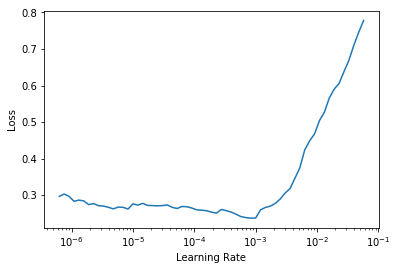

In [30]:
learn.recorder.plot()

In [31]:
learn.unfreeze()
# This time, use different learning rate for different layers. 
# We do this by passing lower to higher learning rate range.
# Here slice() is python slice object, which is simialr to array/list slicing conceptually.
learn.fit_one_cycle(5, max_lr=slice(1e-6,1e-3))

Total time: 00:20
epoch  train_loss  valid_loss  error_rate
1      0.348520    0.726579    0.245283    (00:04)
2      0.301828    0.706428    0.169811    (00:04)
3      0.326719    0.701779    0.169811    (00:04)
4      0.294711    0.720522    0.188679    (00:04)
5      0.287195    0.709617    0.188679    (00:04)



That's not a very accurate model! But, it is better off.<br/>
Reason for better training this is that we are using very low learning rates for initial layers, while high learning rate end layers. Which retains the learnings in pretrained model's initial layers by learning at slow rate for them compared to end layers. 

## Training: resnet50

Now we will train in the same way as before but with one caveat: instead of using resnet34 as our backbone we will use resnet50 (resnet34 is a 34 layer residual network while resnet50 has 50 layers. Later in the course you can learn the details in the [resnet paper](https://arxiv.org/pdf/1512.03385.pdf)).

Basically, resnet50 usually performs better because it is a deeper network with more parameters. Let's see if we can achieve a higher performance here.

In [18]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(), size=299, bs=32)
data.normalize(imagenet_stats)

In [19]:
learn = create_cnn(data, models.resnet50, metrics=error_rate)

In [21]:
learn.fit_one_cycle(10)

Total time: 01:09
epoch  train_loss  valid_loss  error_rate
1      0.373444    0.911184    0.291667    (00:06)
2      0.343208    0.989916    0.333333    (00:06)
3      0.303287    0.996005    0.250000    (00:07)
4      0.295437    1.162555    0.291667    (00:07)
5      0.289391    1.209405    0.333333    (00:06)
6      0.256337    1.235134    0.312500    (00:06)
7      0.239216    1.269647    0.333333    (00:06)
8      0.214448    1.254040    0.333333    (00:06)
9      0.203035    1.245860    0.333333    (00:07)
10     0.187892    1.231261    0.333333    (00:06)



As we can see above, training loss is going down, but validation loss is quite up from 3rd epoch. It means our model is diverging. Hence, we should stop training. 

In [24]:
learn.save('all-sugarcane-diseases-stage-1-50')

It's astonishing that it's possible to recognize indian classical dance  forms so accurately! Let's see if full fine-tuning helps:

In [25]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

Total time: 00:18
epoch  train_loss  valid_loss  error_rate
1      0.178063    1.232448    0.312500    (00:10)
2      0.156254    1.215203    0.312500    (00:08)



In this case we can see that it has started over-fitting. Training loss is less than validation loss! So let's go back to our previous model.

In [27]:
learn.load('all-sugarcane-diseases-stage-1-50')

In [28]:
interp = ClassificationInterpretation.from_learner(learn)

In [29]:
interp.confusion_matrix()

array([[16,  1,  1,  0],
       [ 1,  5,  1,  0],
       [ 6,  1,  2,  2],
       [ 2,  1,  0,  9]])

In [30]:
# No wrong predictions, zero confusion!
interp.most_confused(min_val=1)

[('mosaic', 'rust', 6),
 ('mosaic', 'white-leaf-disease', 2),
 ('white-leaf-disease', 'rust', 2)]